In [77]:
# This block enables local development of the scripts in the `src` folder while using the functions directly in this notebook without restart
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modules

## Python

In [78]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

## Package

In [79]:
sys.path.append(r"C:\Users\SachaGobeyn\GitHub\CNWS-processing-scripts\cnws\src\cfactor")
from cfactor import cfactor,init
from general import initialize_files,prepare_parcel_input

# Trailrun Maarkebeek

## Gewasgegevens

In [4]:
#path_inputdata = r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\C-factor\2. ANALYSES\-testtutorial\inputdata"
path_sources = os.path.join("..","..","src","cfactor","data","raw")
path_tempdata = os.path.join("..","..","src","cfactor","temp")
path_resmap  = os.path.join(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\C-factor\2. ANALYSES\analyse_Vlaanderen\Maarkedal")

paths_teeltdata= initialize_files(path_sources)

## Percelenkaart

In [5]:
in_Shp = {}
in_Shp["2015"] = Path(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\DATA\GIS-data\thematic\Landbouwgebruikspercelen\LandbouwVisserij\Landbouwgebruikspercelen_2015_(toestand_10-08-2016)_la72.shp")
in_Shp["2016"] = Path(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\DATA\GIS-data\thematic\Landbouwgebruikspercelen\LandbouwVisserij\Landbouwgebruikspercelen_2016_(toestand_16-01-2017)_la72.shp")
clip_Shp = Path(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\C-factor\2. ANALYSES\analyse_Vlaanderen\Maarkedal\catchment_shape\Maarkebeek.shp")

parcel_list = prepare_parcel_input(in_Shp,clip_Shp,path_tempdata)

## Run cfactor model for Maarkebeek

In [13]:
parcel, crop_prop, ggg, grid = init(parcel_list,paths_teeltdata,2016)
out = cfactor(parcel, grid, ggg, crop_prop, 2016,
                                        output_map=os.path.join(path_resmap),ffull_output=True, 
                                        multiprocessing=True)

Some crop inputdata are incomplete, removing records


# Volledig Vlaanderen

In [73]:
catchments = ["Demerbekken"]
             #   ["Bekken_Brugse_polders","Bekken_Gentse_kanalen","Beneden-Scheldebekken",
             # "Boven-scheldebekken","Demerbekken","Dijlebekken","Ijzerbekken","Leiebekken",
             # "Maasbekken_N","Maasbekken_E","Netebekken","Voeren"]
catchMap =  r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\Modelberekeningen\v8\Vlaanderen_Bekkens\catchments"
resMap = r"C:/Users/SachaGobeyn/Dropbox (Fluves)/ALBON/C-factor/2. ANALYSES/analyse_Vlaanderen/"

## Prepare parcels

In [74]:
in_Shp = {}
in_Shp["2015"] = Path(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\DATA\GIS-data\thematic\Landbouwgebruikspercelen\LandbouwVisserij\Landbouwgebruikspercelen_2015_(toestand_10-08-2016)_la72.shp")
in_Shp["2016"] = Path(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\DATA\GIS-data\thematic\Landbouwgebruikspercelen\LandbouwVisserij\Landbouwgebruikspercelen_2016_(toestand_16-01-2017)_la72.shp")

for i in catchments:
    print(i)
    clip_Shp = Path(os.path.join(catchMap,"%s.shp"%i))
    parcel_list = prepare_parcel_input(in_Shp,clip_Shp,path_tempdata)
    parcel_list = pd.read_csv(os.path.join(resMap,"parcel_list_%s.csv"%i))
    parcel, crop_prop, ggg, grid = init(parcel_list,paths_teeltdata,2016)
    parcel.to_csv(os.path.join(resMap,"parcel_list_%s.shp"%i))
    #parcel, crop_prop, ggg, grid = init(parcel_list,paths_teeltdata,2016)
    #out = cfactor(parcel, grid, ggg, crop_prop, 2016,
    #                                        output_map=os.path.join(path_resmap),ffull_output=True, 
    #                                        multiprocessing=True)

Demerbekken
Some crop inputdata are incomplete, removing records


## Run cfactor

In [80]:
for i in catchments:
    parcel =  pd.read_csv(os.path.join(resMap,"parcel_list_%s.shp"%i))
    out = cfactor(parcel, grid, ggg, crop_prop, 2016,
                                            output_map=os.path.join(path_resmap),ffull_output=False, 
                                            multiprocessing=True)
    out.to_csv(os.path.join(resMap,"cfactor_%s.csv"%i))

## Analyse

### load

In [81]:
cfactor = []
parcellists = []

catchments_ = ["Demerbekken"]
for i in catchments_:
    parcel_list = pd.read_csv(os.path.join(resMap,"parcel_list_%s.csv"%i))
    parcel_list["catchm"] = i
    parcellists.append(parcel_list)
    parcel_list = parcel_list[parcel_list["jaar"]==2016]
    gewas = parcel_list[["perceel_id","GWSCOD","catchm"]][parcel_list["type"]==2]
    parcel_list = parcel_list.groupby(["perceel_id","REF_ID","catchm"]).aggregate({"type":np.sum}).reset_index()
    parcel_list = parcel_list[parcel_list["type"]<7]
    temp = pd.read_csv(os.path.join(resMap,"cfactor_%s.csv"%i))
    temp = temp.merge(parcel_list,on="perceel_id",how="left").merge(gewas,on="perceel_id",how="left")
    c.append(temp)
    
parcellists = pd.concat(parcellists)
c = pd.concat(c)

types = {2:"H",3:"V+H",5:"H+N",6:"V+H+N"}

c = c.replace(types)

NameError: name 'c' is not defined

### boxplot

In [ ]:
for i in gewas["GWSCOD"].unique()[0:10]:
    fig,ax = plt.subplots()
    ax =  sns.boxplot(x="GWSCOD", y="C", data=c[c["GWSCOD"]==i],hue="type")

(array([3.09964e+05, 1.08690e+04, 3.10000e+02, 6.73790e+04, 2.39620e+04,
        3.40000e+01, 6.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <a list of 10 Patch objects>)

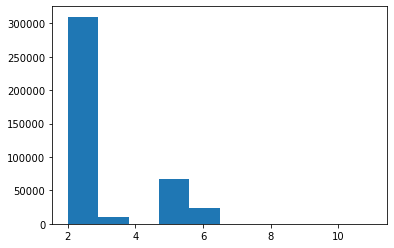

In [61]:
plt.hist(cfactor["type"])

In [47]:
parcellists[parcellists["perceel_id"]==74865]

,Unnamed: 0,REF_ID,CODE_OBJ,perceel_id,jaar,type,GWSCOD,catchm
159685,251631,1645845981,00002802642418F4,74865,2016,2,311,Demerbekken
159686,270957,1645845981,0000280263B19839,74865,2016,2,9710,Demerbekken
159687,387995,1645845981,00002802642418F4,74865,2016,3,321,Demerbekken
157283,243432,1540425775,000028025F13B3B1,74865,2016,2,3,Ijzerbekken


In [48]:
temp = gpd.read_file(r"C:\Users\SachaGobeyn\Dropbox (Fluves)\ALBON\DATA\GIS-data\thematic\Landbouwgebruikspercelen\LandbouwVisserij\Landbouwgebruikspercelen_2016_(toestand_16-01-2017)_la72.shp")

,CODE_OBJ,CMP_COD,ANONI_NR,PRC_NMR,AANG_OPP,GRAF_OPP,REF_OPP,REF_ID,GWSCOD_V,GWSNAM_V,...,LANDBSTR,STAT_AAR,PCT_EKBG,PRC_GEM,PRC_NIS,X_REF,Y_REF,WGS84_LG,WGS84_BG,geometry
464490,00002802642418F4,2016,79587870052852,21,0.61,0.9247,0.92,1645845981,None,None,...,ZL,None,None,ALKEN,73001,213023,173611,"5°15'50""","50°52'10""","POLYGON ((212958.380 173613.670, 212971.330 17..."
505288,0000280263B19839,2016,37840677812182,42,0.90,0.9247,0.92,1645845981,None,None,...,ZL,None,None,ALKEN,73001,213023,173611,"5°15'50""","50°52'10""","POLYGON ((212958.380 173613.670, 212971.330 17..."


In [53]:
cfactor

,Unnamed: 0,perceel_id,C,SLR_0,SLR_1,SLR_2,SLR_3,SLR_4,SLR_5,SLR_6,...,H_19,H_20,H_21,H_22,H_23,REF_ID,catchm_x,type,GWSCOD,catchm_y
0,0,0.0,0.485868,0.009650,0.009664,0.009674,0.009683,0.009691,0.009700,0.009707,...,0.025,0.03,0.030,0.030,0.03,434034883,Bekken_Brugse_polders,6,201,Bekken_Brugse_polders
1,1,1.0,0.485868,0.009650,0.009664,0.009674,0.009683,0.009691,0.009700,0.009707,...,0.025,0.03,0.030,0.030,0.03,434034075,Bekken_Brugse_polders,6,201,Bekken_Brugse_polders
2,2,2.0,0.485868,0.009650,0.009664,0.009674,0.009683,0.009691,0.009700,0.009707,...,0.025,0.03,0.030,0.030,0.03,435951342,Bekken_Brugse_polders,6,201,Bekken_Brugse_polders
3,3,3.0,0.249801,0.009410,0.009447,0.009474,0.009498,0.009519,0.009545,0.009563,...,0.000,0.00,0.000,0.000,0.00,1314869958,Bekken_Brugse_polders,2,311,Bekken_Brugse_polders
4,4,4.0,0.105506,0.009410,0.009447,0.009474,0.009498,0.009519,0.009545,0.009563,...,0.030,0.06,0.060,0.060,0.06,935631583,Bekken_Brugse_polders,5,901,Bekken_Brugse_polders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,174,1801.0,0.135459,0.009675,0.009687,0.009695,0.009703,0.009709,0.009717,0.009722,...,0.000,0.00,0.000,0.000,0.00,1645162133,Voeren,2,201,Voeren
1462,175,1802.0,0.015330,0.021417,0.020952,0.020480,0.020005,0.019528,0.019052,0.018655,...,0.030,0.03,0.030,0.030,0.03,1640831485,Voeren,2,60,Voeren
1463,176,1803.0,0.015330,0.021417,0.020952,0.020480,0.020005,0.019528,0.019052,0.018655,...,0.030,0.03,0.030,0.030,0.03,1644201328,Voeren,2,60,Voeren
1464,177,1804.0,0.015330,0.021417,0.020952,0.020480,0.020005,0.019528,0.019052,0.018655,...,0.030,0.03,0.030,0.030,0.03,1642096428,Voeren,2,60,Voeren
